# GNN Training Diagnostics

Visualise loss curves and validation metrics recorded during training. Re-run the training pipeline with the updated logging to populate the history files.

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

def _locate_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        candidate = candidate.resolve()
        if (candidate / 'src').exists():
            return candidate
    raise RuntimeError('Could not locate project root containing "src" directory')

PROJECT_ROOT = _locate_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except ImportError:  # pragma: no cover
    sns = None
    plt.style.use('ggplot')

from src.analysis.performance import load_training_history, load_step_losses

RUN_DIR = Path('outputs/gnn_runs/baseline')
history_df = None
step_df = None
try:
    history_df = load_training_history(RUN_DIR)
except FileNotFoundError as exc:
    print(f'Training history not found: {exc}')
try:
    step_df = load_step_losses(RUN_DIR)
except FileNotFoundError as exc:
    print(f'Step-level losses not found: {exc}')

if history_df is not None and not history_df.empty:
    display(history_df.head())
else:
    print('Run training to generate history metrics.')
if step_df is not None and not step_df.empty:
    display(step_df.head())


,epoch,train_loss,val_weighted_score,val_dispatch_error,val_dispatch_error_mae,val_dispatch_error_rmse,val_dispatch_error_normalized_mae,val_cost_gap,val_cost_gap_mean_gap,val_cost_gap_median_gap,val_cost_gap_max_gap,val_violation_rate,val_violation_rate_mean_rate,val_violation_rate_max_rate,is_best
0,1,674.666114,0.343103,10.236784,10.236784,31.366099,0.072778,-0.939069,-0.939069,-0.940717,0.955478,0.480990,0.480990,0.597501,True
1,2,439.627291,0.341407,10.102111,10.102111,31.318920,0.071837,-0.940139,-0.940139,-0.941512,0.955287,0.477926,0.477926,0.593833,True
2,3,408.684593,0.442438,10.447531,10.447531,31.810514,0.073926,-0.937443,-0.937443,-0.938861,0.954357,0.700948,0.700948,0.828456,False
3,4,394.011158,0.385185,9.780960,9.780960,30.725024,0.069794,-0.942211,-0.942211,-0.943700,0.956465,0.576793,0.576793,0.719818,False
4,5,379.730980,0.350061,10.432464,10.432464,31.772689,0.074051,-0.938449,-0.938449,-0.939919,0.954474,0.495317,0.495317,0.614066,False


,step,epoch,loss
0,25.0,1.0,5938.166758
1,50.0,1.0,2831.392231
2,75.0,1.0,2133.220542
3,100.0,1.0,1860.435317
4,125.0,1.0,1710.584687


## Epoch-level Metrics


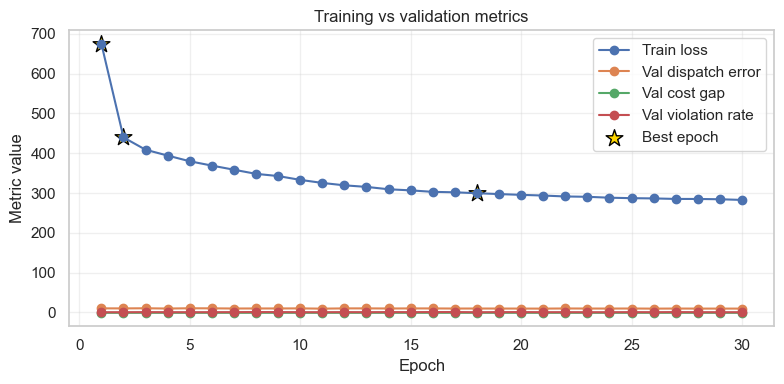

In [3]:
if history_df is not None and not history_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(history_df['epoch'], history_df['train_loss'], marker='o', label='Train loss')
    for col, label in [('val_dispatch_error', 'Val dispatch error'),
                     ('val_cost_gap', 'Val cost gap'),
                     ('val_violation_rate', 'Val violation rate')]:
        if col in history_df:
            ax.plot(history_df['epoch'], history_df[col], marker='o', label=label)
    if 'is_best' in history_df:
        best = history_df[history_df['is_best']]
        if not best.empty:
            ax.scatter(best['epoch'], best['train_loss'], s=160, marker='*', color='gold', edgecolor='black', label='Best epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric value')
    ax.set_title('Training vs validation metrics')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('No epoch history to plot.')


## Step-level Loss


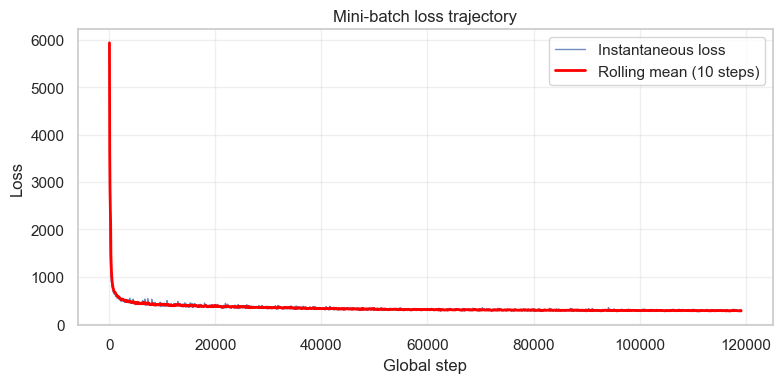

In [4]:
if step_df is not None and not step_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(step_df['step'], step_df['loss'], linewidth=1, alpha=0.8, label='Instantaneous loss')
    if 'step' in step_df:
        rolling = step_df.set_index('step')['loss'].rolling(window=10, min_periods=1).mean()
        ax.plot(rolling.index, rolling.values, color='red', linewidth=2, label='Rolling mean (10 steps)')
    ax.set_xlabel('Global step')
    ax.set_ylabel('Loss')
    ax.set_title('Mini-batch loss trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('No step-level loss data available.')
